In [1]:
import numpy as np
from src.monte_carlo import monte_carlo_mix, Scroll, Item

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
WEAPON_SCROLL_PRICE = {"A": 269, "B": 6.4, "C": 4800, "D": 9.5}
SHIELD_SCROLL_PRICE = {"A": 79, "B": 2000, "C": 1522, "D": 700}
WEAPON_SWORD = {"108": 25000, "107": 15000}

In [4]:
mxb_to_rmb = 56 # 56W mxb = 1rmb
GROVE_ATTACK_PRICE = {
    "10": 1500,
    "11": 2500,
    "12": 5000,
    "13": 14000,
    "14": 700*mxb_to_rmb,
    "15": 2200*mxb_to_rmb,
    "16": 6000*mxb_to_rmb,
    "17": 12500*mxb_to_rmb
}

GROVE_SCROLL_PRICE = {
    "A": 33, 
    "B": 597, 
    "C": 14959, 
    "D": 2325
}
item_price = 2500

SCROLL_A = Scroll("A_10p_+3", success_p=0.11, atk_value=3, destroy_on_fail_p=0.0)
SCROLL_B = Scroll("B_60p_+2", success_p=0.66, atk_value=2, destroy_on_fail_p=0.0)
SCROLL_C = Scroll("C_30p_+3_boom50", success_p=0.33, atk_value=3, destroy_on_fail_p=0.50)
SCROLL_D = Scroll("D_70p_+2_boom50", success_p=0.77, atk_value=2, destroy_on_fail_p=0.50)

SCROLL_SET = {"A": SCROLL_A, "B": SCROLL_B, "C": SCROLL_C, "D": SCROLL_D}
NAME_TO_KEY = {SCROLL_A.name: "A", SCROLL_B.name: "B", SCROLL_C.name: "C", SCROLL_D.name: "D"}  # 便于反查类型键

In [5]:
from src.monte_carlo import stop_all_success, stop_atk_at_least, strategy_fixed_sequence, monte_carlo_mix
from src.monte_carlo import stop_when_fail_or_consume_all_slots, stop_on_first_fail
import matplotlib.pyplot as plt
from src.plot import create_figure

def plot_bar_int(data, ax=None):
    values, counts = np.unique(data, return_counts=True)
    idx = values == 0
    values = np.delete(values, idx)
    counts = np.delete(counts, idx)
    if ax is None:
        plt.bar(values, counts/len(data), width=0.9, align='center', edgecolor='k')
        plt.xticks(values)  # 每个整数一个刻度
    else:
        ax.bar(values, countslen(data), width=0.9, align='center', edgecolor='k')
        ax.set_xticks(values)  # 每个整数一个刻度

def plot_cdf_pdf(data, fig_title):

    num_items = []
    probability = []
    for i in range(0,np.max(data)+1):
        probability.append(np.sum(np.array(data) < i+1) / len(data))
        num_items.append(i+1)

    valid_num_items = range(0, int(np.mean(data) + 3*np.std(data, ddof=1)))
    valid_probability = np.array(probability)[valid_num_items]

    fig, axs = create_figure(1,3)
    fig.suptitle(fig_title)
    ax1 = fig.add_subplot(axs[0])
    ax1.plot(valid_probability)
    ax1.set_title("CDF")

    ax2 = fig.add_subplot(axs[1])
    ax2.hist(data, bins=np.arange(0,np.max(data),5))
    # ax2.axvline(np.max(valid_num_items), color='r')
    ax2.axvline(np.mean(data), color='r')
    ax2.set_title("PDF")
    ticks = ax2.get_yticks()
    ax2.set_yticks(ticks)  # 固定刻度位置，防止后续自动变化
    ax2.set_yticklabels([f"{t/len(data):g}" for t in ticks])

    ax3 = fig.add_subplot(axs[2])
    ax3.plot(np.diff(valid_probability))

In [6]:
def calculate_statistics(results):
    scrolls_dist = {}
    for scroll_name, scroll_distribution in results['scrolls_distribution'].items():
        scrolls_dist[scroll_name] = np.mean(scroll_distribution)

    num_groves = np.mean(results['items_distribution'])
    
    bad_groves_dist = {}
    v,c = np.unique(results['items_properties']['atk_value']['good'], return_counts=True)
    grove_sell = 0
    for v_i,c_i in zip(v,c):
        if v_i < np.max(v):
            bad_groves_dist[str(v_i)] = c_i

    return scrolls_dist, num_groves, bad_groves_dist

seed: 1758608527


Monte Carlo: 100%|██████████| 100000/100000 [00:09<00:00, 10154.05it/s]



Number of Groves cost: 6.19803
Number of D_70p_+2_boom50 cost: 22.6443
bad grove value: 1018.325
Total Cost 68143.07250000001
Actual Price 39200


Text(0.5, 1.0, "['D', 'D', 'D', 'D', 'D', 'D', 'D']")

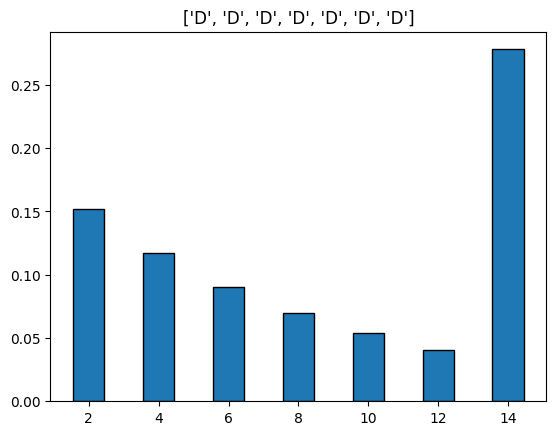

In [7]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_all_success()
scroll_list = ["D", "D", "D", "D", "D", "D", "D"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = stop_when_fail_or_consume_all_slots(strat1, target, stop_if_fail=True)
# Procedure = stop_on_first_fail(strat1, target)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])
max_attack = np.max(results['items_properties']['atk_value']['good'])
print("")

scrolls_dist, num_groves, bad_groves_dist = calculate_statistics(results)
print(f"Number of Groves cost: {num_groves}")

scroll_cost = 0
for key, value in scrolls_dist.items():
    scroll_i = GROVE_SCROLL_PRICE[NAME_TO_KEY[key]] * value
    scroll_cost += scroll_i
    print(f"Number of {key} cost: {value}")

bad_grove_value = 0
for key, value in bad_groves_dist.items():
    if key in GROVE_ATTACK_PRICE.keys():
        bad_grove_value += GROVE_ATTACK_PRICE[key] * value
bad_grove_value /= trials
print(f"bad grove value: {bad_grove_value}")

total_cost = scroll_cost + num_groves*item_price
print(f"Total Cost {total_cost}")
print(f"Actual Price {GROVE_ATTACK_PRICE[str(max_attack)]}")

data = results['items_properties']['atk_value']['good']
plot_bar_int(data)
plt.title(scroll_list)

seed: 1758608537


Monte Carlo:   0%|          | 0/100000 [00:00<?, ?it/s]

Monte Carlo: 100%|██████████| 100000/100000 [01:01<00:00, 1630.81it/s]



Number of Groves cost: 43.75355
Number of D_70p_+2_boom50 cost: 21.70406
Number of A_10p_+3 cost: 43.75355
bad grove value: 13361.2
Total Cost 161289.68164999998
Actual Price 123200


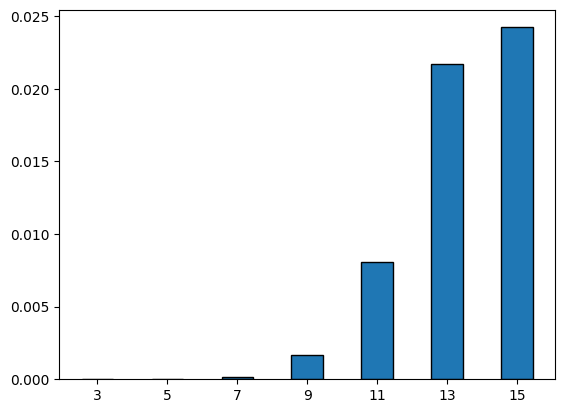

In [8]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_all_success()
scroll_list = ["A", "D", "D", "D", "D", "D", "D"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = stop_when_fail_or_consume_all_slots(strat1, target, stop_if_fail=True)
# Procedure = stop_on_first_fail(strat1, target)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])
max_attack = np.max(results['items_properties']['atk_value']['good'])
print("")

scrolls_dist, num_groves, bad_groves_dist = calculate_statistics(results)
print(f"Number of Groves cost: {num_groves}")

scroll_cost = 0
for key, value in scrolls_dist.items():
    scroll_i = GROVE_SCROLL_PRICE[NAME_TO_KEY[key]] * value
    scroll_cost += scroll_i
    print(f"Number of {key} cost: {value}")

bad_grove_value = 0
for key, value in bad_groves_dist.items():
    if key in GROVE_ATTACK_PRICE.keys():
        bad_grove_value += GROVE_ATTACK_PRICE[key] * value
bad_grove_value /= trials
print(f"bad grove value: {bad_grove_value}")

total_cost = scroll_cost + num_groves*item_price
print(f"Total Cost {total_cost}")
print(f"Actual Price {GROVE_ATTACK_PRICE[str(max_attack)]}")

data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

seed: 1758608602


Monte Carlo: 100%|██████████| 100000/100000 [02:24<00:00, 692.91it/s]



Number of Groves cost: 101.71971
Number of C_30p_+3_boom50 cost: 3.0284
Number of D_70p_+2_boom50 cost: 35.47944
Number of A_10p_+3 cost: 101.71971
bad grove value: 15341.11
Total Cost 385447.55903
Actual Price 336000


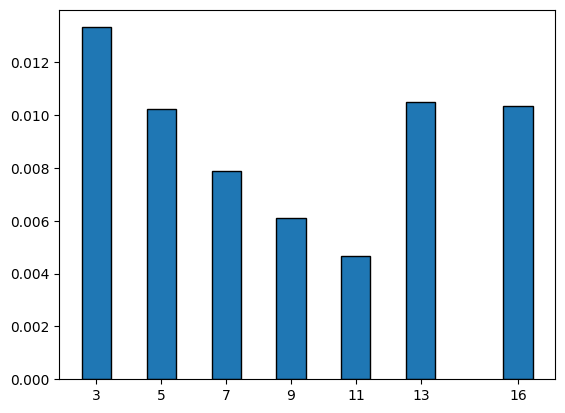

In [9]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_all_success()
scroll_list = ["A", "D", "D", "D", "D", "D", "C"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = stop_when_fail_or_consume_all_slots(strat1, target, stop_if_fail=True)
# Procedure = stop_on_first_fail(strat1, target)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])
max_attack = np.max(results['items_properties']['atk_value']['good'])
print("")

scrolls_dist, num_groves, bad_groves_dist = calculate_statistics(results)
print(f"Number of Groves cost: {num_groves}")

scroll_cost = 0
for key, value in scrolls_dist.items():
    scroll_i = GROVE_SCROLL_PRICE[NAME_TO_KEY[key]] * value
    scroll_cost += scroll_i
    print(f"Number of {key} cost: {value}")

bad_grove_value = 0
for key, value in bad_groves_dist.items():
    if key in GROVE_ATTACK_PRICE.keys():
        bad_grove_value += GROVE_ATTACK_PRICE[key] * value
bad_grove_value /= trials
print(f"bad grove value: {bad_grove_value}")

total_cost = scroll_cost + num_groves*item_price
print(f"Total Cost {total_cost}")
print(f"Actual Price {GROVE_ATTACK_PRICE[str(max_attack)]}")

data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

seed: 1758609189


Monte Carlo: 100%|██████████| 100000/100000 [05:46<00:00, 288.84it/s]



Number of Groves cost: 238.03031
Number of C_30p_+3_boom50 cost: 12.25275
Number of D_70p_+2_boom50 cost: 73.84601
Number of A_10p_+3 cost: 238.03031
bad grove value: 47671.352
Total Cost 957911.63573
Actual Price 700000


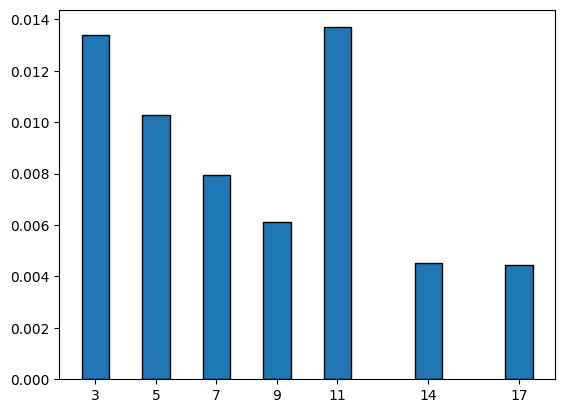

In [11]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_all_success()
scroll_list = ["A", "D", "D", "D", "D", "C", "C"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = stop_when_fail_or_consume_all_slots(strat1, target, stop_if_fail=True)
# Procedure = stop_on_first_fail(strat1, target)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])
max_attack = np.max(results['items_properties']['atk_value']['good'])
print("")

scrolls_dist, num_groves, bad_groves_dist = calculate_statistics(results)
print(f"Number of Groves cost: {num_groves}")

scroll_cost = 0
for key, value in scrolls_dist.items():
    scroll_i = GROVE_SCROLL_PRICE[NAME_TO_KEY[key]] * value
    scroll_cost += scroll_i
    print(f"Number of {key} cost: {value}")

bad_grove_value = 0
for key, value in bad_groves_dist.items():
    if key in GROVE_ATTACK_PRICE.keys():
        bad_grove_value += GROVE_ATTACK_PRICE[key] * value
bad_grove_value /= trials
print(f"bad grove value: {bad_grove_value}")

total_cost = scroll_cost + num_groves*item_price
print(f"Total Cost {total_cost}")
print(f"Actual Price {GROVE_ATTACK_PRICE[str(max_attack)]}")

data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

In [ ]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_all_success()
scroll_list = ["C", "C", "C", "C", "C", "C", "C"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = stop_when_fail_or_consume_all_slots(strat1, target, stop_if_fail=True)
# Procedure = stop_on_first_fail(strat1, target)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])
max_attack = np.max(results['items_properties']['atk_value']['good'])
print("")

scrolls_dist, num_groves, bad_groves_dist = calculate_statistics(results)
print(f"Number of Groves cost: {num_groves}")

scroll_cost = 0
for key, value in scrolls_dist.items():
    scroll_i = GROVE_SCROLL_PRICE[NAME_TO_KEY[key]] * value
    scroll_cost += scroll_i
    print(f"Number of {key} cost: {value}")

bad_grove_value = 0
for key, value in bad_groves_dist.items():
    if key in GROVE_ATTACK_PRICE.keys():
        bad_grove_value += GROVE_ATTACK_PRICE[key] * value
bad_grove_value /= trials
print(f"bad grove value: {bad_grove_value}")

total_cost = scroll_cost + num_groves*item_price
print(f"Total Cost {total_cost}")
print(f"Actual Price {GROVE_ATTACK_PRICE[str(max_attack)]}")

data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

seed: 1758609917


Monte Carlo:   3%|▎         | 2527/100000 [01:48<1:12:31, 22.40it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x75e08375aba0>>
Traceback (most recent call last):
  File "/home/tree/miniconda3/envs/MDP/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Monte Carlo:   3%|▎         | 2696/100000 [01:57<1:06:46, 24.29it/s]

In [ ]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_all_success()
scroll_list = ["A", "C", "C", "C", "C", "C", "C"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = stop_when_fail_or_consume_all_slots(strat1, target, stop_if_fail=True)
# Procedure = stop_on_first_fail(strat1, target)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])
max_attack = np.max(results['items_properties']['atk_value']['good'])
print("")

scrolls_dist, num_groves, bad_groves_dist = calculate_statistics(results)
print(f"Number of Groves cost: {num_groves}")

scroll_cost = 0
for key, value in scrolls_dist.items():
    scroll_i = GROVE_SCROLL_PRICE[NAME_TO_KEY[key]] * value
    scroll_cost += scroll_i
    print(f"Number of {key} cost: {value}")

bad_grove_value = 0
for key, value in bad_groves_dist.items():
    if key in GROVE_ATTACK_PRICE.keys():
        bad_grove_value += GROVE_ATTACK_PRICE[key] * value
bad_grove_value /= trials
print(f"bad grove value: {bad_grove_value}")

total_cost = scroll_cost + num_groves*item_price
print(f"Total Cost {total_cost}")
print(f"Actual Price {GROVE_ATTACK_PRICE[str(max_attack)]}")

data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

In [ ]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_all_success()
scroll_list = ["A", "A", "C", "C", "C", "C", "C"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = stop_when_fail_or_consume_all_slots(strat1, target, stop_if_fail=True)
# Procedure = stop_on_first_fail(strat1, target)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])
max_attack = np.max(results['items_properties']['atk_value']['good'])
print("")

scrolls_dist, num_groves, bad_groves_dist = calculate_statistics(results)
print(f"Number of Groves cost: {num_groves}")

scroll_cost = 0
for key, value in scrolls_dist.items():
    scroll_i = GROVE_SCROLL_PRICE[NAME_TO_KEY[key]] * value
    scroll_cost += scroll_i
    print(f"Number of {key} cost: {value}")

bad_grove_value = 0
for key, value in bad_groves_dist.items():
    if key in GROVE_ATTACK_PRICE.keys():
        bad_grove_value += GROVE_ATTACK_PRICE[key] * value
bad_grove_value /= trials
print(f"bad grove value: {bad_grove_value}")

total_cost = scroll_cost + num_groves*item_price
print(f"Total Cost {total_cost}")
print(f"Actual Price {GROVE_ATTACK_PRICE[str(max_attack)]}")

data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

In [ ]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_all_success()
scroll_list = ["A", "A", "A", "C", "C", "C", "C"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = stop_when_fail_or_consume_all_slots(strat1, target, stop_if_fail=True)
# Procedure = stop_on_first_fail(strat1, target)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])
max_attack = np.max(results['items_properties']['atk_value']['good'])
print("")

scrolls_dist, num_groves, bad_groves_dist = calculate_statistics(results)
print(f"Number of Groves cost: {num_groves}")

scroll_cost = 0
for key, value in scrolls_dist.items():
    scroll_i = GROVE_SCROLL_PRICE[NAME_TO_KEY[key]] * value
    scroll_cost += scroll_i
    print(f"Number of {key} cost: {value}")

bad_grove_value = 0
for key, value in bad_groves_dist.items():
    if key in GROVE_ATTACK_PRICE.keys():
        bad_grove_value += GROVE_ATTACK_PRICE[key] * value
bad_grove_value /= trials
print(f"bad grove value: {bad_grove_value}")

total_cost = scroll_cost + num_groves*item_price
print(f"Total Cost {total_cost}")
print(f"Actual Price {GROVE_ATTACK_PRICE[str(max_attack)]}")

data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

In [10]:
# data = results['items_properties']['atk_value']['good']
# plot_bar_int(data)

# # data = results['scrolls_distribution']['D_70p_+2_boom50']
# # plot_cdf_pdf(data, "Scrolls D-D-D-D-D-D-D")

# plot_cdf_pdf(results['items_distribution'], "Groves D-D-D-D-D-D-D")